In [11]:
import pandas as pd
import os
import numpy as np
from extract_audio_functions import * # importa como módulo completo
import importlib


# Leer el CSV
df = pd.read_csv("./dataset/spotify_songs_download.csv")

paths_audios_wav=df['path_download_wav'].tolist()
paths_audios_mp3=df['path_download'].tolist()


In [ ]:
from extract_audio_functions import *

# pasar de mp3 a wav
for i in range(0,len(paths_audios_wav)):
    entrad= paths_audios_mp3[i]
    salida = paths_audios_wav[i]
    if entrad.endswith(".mp3"):
        # el path y el directorio de salida
        transform_mp3_to_wav(entrad,salida,tiempo_recorte=30) 
    else:
        print(f"El archivo {entrad} no es un mp3, se omite la conversión.")


In [ ]:

# Obtener listas desde el DataFrame
paths_audios_wav = df["path_download_wav"].tolist()

mfcc_por_track = []
for path_wav in paths_audios_wav:
    mfcc = extract_mfcc(path_wav, ventana=0.5)
    mfcc_por_track.append( mfcc)



In [ ]:
# cada audio
mfcc_por_track[0].shape

(60, 13)

In [ ]:
# apilar los mfcc
mfcc_apilados= np.vstack(mfcc_por_track)
print(f"Forma de los MFCC apilados: {mfcc_apilados.shape}")

Forma de los MFCC apilados: (174780, 13)


In [ ]:
#NORMALIZAR LA DATA PARA EL KMEANS
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
mfcc_normalizado=scaler.fit_transform(mfcc_apilados)

# Sacamos lo Codeword   -> acoustic word
Kmeans =construir_codebook(mfcc_normalizado,n_clusters=120)#110 opcional
#inertia : cuando se aumenta el K la inertia tiende a 0  : significa que tanto estan pegados los puntos. 

#save scaler y kmeans -> para procesar luego una query
guardar_objeto(scaler,"scaler.joblib")
guardar_objeto(Kmeans,"Kmeans.joblib")

Initialization complete
Iteration 0, inertia 1023907.8125.
Iteration 1, inertia 938193.625.
Iteration 2, inertia 919057.75.
Iteration 3, inertia 909977.6875.
Iteration 4, inertia 904359.375.
Iteration 5, inertia 900414.875.
Iteration 6, inertia 897389.75.
Iteration 7, inertia 894917.875.
Iteration 8, inertia 892918.8125.
Iteration 9, inertia 891289.6875.
Iteration 10, inertia 889948.125.
Iteration 11, inertia 888792.625.
Iteration 12, inertia 887829.5.
Iteration 13, inertia 887016.75.
Iteration 14, inertia 886292.125.
Iteration 15, inertia 885653.375.
Iteration 16, inertia 885090.6875.
Iteration 17, inertia 884598.5.
Iteration 18, inertia 884137.125.
Iteration 19, inertia 883731.625.
Iteration 20, inertia 883374.6875.
Iteration 21, inertia 883070.9375.
Iteration 22, inertia 882802.875.
Iteration 23, inertia 882563.75.
Iteration 24, inertia 882343.625.
Iteration 25, inertia 882135.25.
Iteration 26, inertia 881924.4375.
Iteration 27, inertia 881732.625.
Iteration 28, inertia 881543.125.


In [ ]:
print(Kmeans.cluster_centers_.shape)  # centroides o acustiword


(120, 13)


In [12]:

ids = df['id'].tolist() 

diccionary={}
for i in range(0,len(mfcc_por_track)):
    mfcc = mfcc_por_track[i]

    #volvemos a normalizar 
    mfcc_scaled = scaler.transform(mfcc)

    hist = histogram_audio(mfcc_scaled, Kmeans)
    diccionary[ids[i]] = hist.tolist() #   para guardar id : histograma

    # (DEBUG) mostrar mapeo
    print(f"Audio {i} → {hist.tolist()}")

# Guardar en JSON
guardar_json(diccionary)


Audio 0 → [0.0, 0.05913123959890826, 0.0, 0.0, 0.0, 0.0, 0.05913123959890826, 0.0, 0.0, 0.0, 0.0, 0.05913123959890826, 0.0, 0.0, 0.11826247919781652, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23652495839563303, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11826247919781652, 0.0, 0.35478743759344955, 0.05913123959890826, 0.0, 0.0, 0.0, 0.35478743759344955, 0.0, 0.0, 0.23652495839563303, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11826247919781652, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11826247919781652, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.35478743759344955, 0.05913123959890826, 0.0, 0.0, 0.0, 0.05913123959890826, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11826247919781652, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17739371879672478, 0.0, 0.0, 0.0, 0.0, 0.05913123959890826, 0.0, 0.0, 0.0, 0.17739371879672478, 0.0, 0.0, 0.05913123959890826, 0.0, 0.0, 0.5913123959890826, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Audio 1 → [0.05643326479831003, 0.0, 0.0, 0.0564332647

In [13]:
from extract_audio_functions import *
import os

# TEST MUSIC
def cargar_modelos_y_datos():
    df = pd.read_csv("./dataset/spotify_songs_download.csv")
    scaler = cargar_objeto("scaler.joblib")
    kmeans_model = cargar_objeto("Kmeans.joblib")
    return df, scaler, kmeans_model
def sacar_path_con_id(df,id) -> str:
    path=df[df['id'] == id ]['path_download_wav'].values[0]
    return path

def extraer_mfcc_por_path(path, scaler) -> list[list[float]]:
    mfcc_test = extract_mfcc(path)
    return scaler.transform(mfcc_test)

def obtener_recomendaciones_por_id(id: str, k: int = 5) -> tuple[dict[str, any], int]:
    try:
        df, scaler, kmeans_model = cargar_modelos_y_datos()

        if id not in df['id'].values:
            return {"error": "Track ID no encontrado"}, 404
        
        path=sacar_path_con_id(df,id)
        mfcc_normalizado = extraer_mfcc_por_path(path,scaler)
        histograma = histogram_audio(mfcc_normalizado, kmeans_model)
        recomendaciones = knn_manhattan(histograma, k=k)
        
        # Convertir a dict si es lista de tuplas
        recomendaciones_dict = {track: dist for track, dist in recomendaciones}

        return  recomendaciones_dict

    except Exception as e:
        exit(1) 

#--------------- TEST adudio MP3 --------------
#para poder hacer recomendacion de audio necesita path
# para el SQL 
def obtener_recomendaciones_por_audio_mp3(path_mp3,k=5):
    """
        path absoulta d la ruta
    """
    directorio='./audios_temp'
    if not os.path.isdir(directorio):
        print(f"creando directorio ... {directorio}")
        os.makedirs(directorio)

    path_salida = directorio+"/temp.wav"
    path_mp3_salida_wav=os.path.abspath(path_salida)

    transform_mp3_to_wav(path_mp3,path_mp3_salida_wav)
    scaler = cargar_objeto("scaler.joblib")
    kmeans_model = cargar_objeto("Kmeans.joblib")
    mfcc_normalizado=extraer_mfcc_por_path(path_mp3_salida_wav,scaler)

    histograma = histogram_audio(mfcc_normalizado, kmeans_model)
    recomendaciones = knn_cosine(histograma, k=k)
    recomendaciones_dict=dict(recomendaciones)
    return recomendaciones_dict



# ---- TEST INSERT AUDIO ---- 
def insert_audio(path_mp3: str, id: str = None, json_path: str = "histogramas_acusticos.json"):
    """
    Inserta un nuevo audio: convierte, extrae MFCC, genera histograma y lo guarda en JSON.
    """
    os.makedirs('./audios_wav', exist_ok=True)
    name=os.path.basename(path_mp3)
    path_wav = os.path.abspath(os.path.join('audios_temp', f'{name}.wav'))

    transform_mp3_to_wav(path_mp3, path_wav, tiempo_recorte=30)

    scaler = cargar_objeto("scaler.joblib")
    kmeans_model = cargar_objeto("Kmeans.joblib")

    mfcc = extract_mfcc(path_wav)
    mfcc_normalizado = scaler.transform(mfcc)
    hist = histogram_audio(mfcc_normalizado, kmeans_model)

    try:
        with open("histogramas_acusticos.json") as f:
            diccionario = json.load(f)
    except FileNotFoundError:
        diccionario = {}

    diccionario[id] = hist.tolist()
    guardar_json(diccionario, json_path)
    print("[DEBUG]  isertado el audio ",name," id: ",id ,"correctamente")

#insert_audio("C:\Users\jefersson\Downloads\capital_cities.mpeg","2913")


In [14]:
#path_mp3="C:\\Users\\jefersson\\Downloads\\coldplay.mpeg"
path_mp3="C:\\Users\\jefersson\\Downloads\\capital_cities.mpeg" 

recomendaciones=obtener_recomendaciones_por_audio_mp3(path_mp3=path_mp3,k=5)


import os
cwd = os.getcwd()
print("Directorio actual:", cwd)

path=os.path.join(cwd,'audio_temp','temp.wav')
print(path)

print(os.path.abspath('./audios_wav/jessie j - masterpiece.wav'))
print(os.path.abspath('.\\audios\\ann marie, yk osiris - secret .mp3'))


creando directorio ... ./audios_temp
Convertido: C:\Users\jefersson\Downloads\capital_cities.mpeg → c:\Users\jefersson\Desktop\ANACONDA\audios_temp\temp.wav
Directorio actual: c:\Users\jefersson\Desktop\ANACONDA
c:\Users\jefersson\Desktop\ANACONDA\audio_temp\temp.wav
c:\Users\jefersson\Desktop\ANACONDA\audios_wav\jessie j - masterpiece.wav
c:\Users\jefersson\Desktop\ANACONDA\audios\ann marie, yk osiris - secret .mp3


In [16]:
result_dict=recomendaciones

In [17]:
#result_dict,status = obtener_recomendaciones_por_track('7qpuECko60EoztznowMWj1',k=5)
#result_dict=result_dict['recomendaciones']
import pandas as pd

# Leer el CSV
df = pd.read_csv("./dataset/spotify_songs_download.csv")


filas = df[df['id'].isin(result_dict)]
filas
# Agregar la columna 'score' con la distancia correspondiente
filas['score'] = filas['id'].map(result_dict)
#print(filas)


In [18]:
import pandas as pd

pd.set_option('display.max_colwidth', None)

# Leer dataset original con géneros
df_genre = pd.read_csv('./dataset/spotify_songs_download_FINAL.csv')

# Ordenar por score
filas = filas.sort_values('score')

# Hacer el join por id
join_data = pd.merge(df_genre, filas, on='id', how='inner')

# Mostrar columnas deseadas
join_data.sort_values('score')[['score', 'track_artist_x', 'track_name_x', 'playlist_genre', 'playlist_subgenre', 'path_download_y']]



,score,track_artist_x,track_name_x,playlist_genre,playlist_subgenre,path_download_y


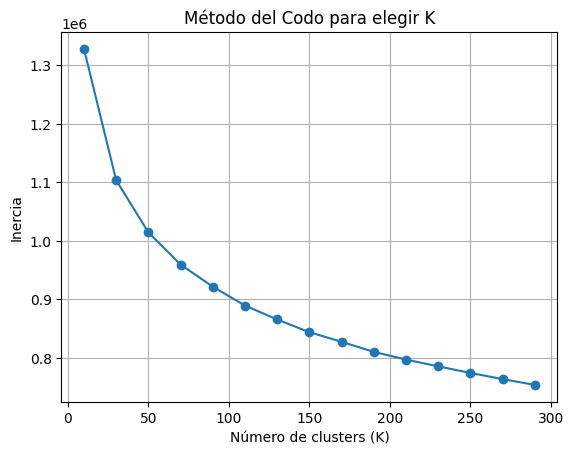

In [17]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
mfcc_normalizado=scaler.fit_transform(mfcc_apilados)

inertias = []
K_range = range(10, 300, 20)
for k in K_range:
    model = KMeans(n_clusters=k, random_state=0).fit(mfcc_normalizado)
    inertias.append(model.inertia_)

plt.plot(K_range, inertias, marker='o')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Inercia')
plt.title('Método del Codo para elegir K')
plt.grid()
plt.show()
